# Miniprojekt 3

## Generieren von Bloch-Vektoren

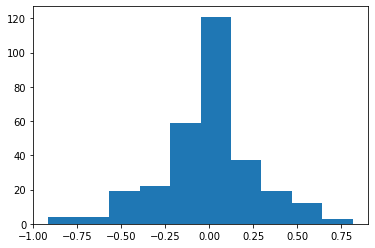

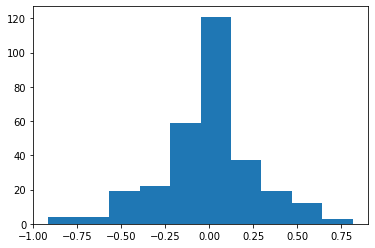

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

SAMPLE_SIZE = 300
r_arr = []
np.random.seed(4)
for i in range(SAMPLE_SIZE):
    r = np.random.uniform(0,1)
    phi = np.random.uniform(0, 2 * np.pi)
    theta = np.random.uniform(0, np.pi)
    r_vec = [r * np.sin(theta) * np.cos(phi), r * np.sin(theta) * np.sin(phi), r * np.cos(theta)]
    r_arr.append(r_vec)

pauli = np.array([[[0, 1], [1, 0]], [[0, -1j], [1j, 0]], [[1, 0], [0, -1]]])
rho_arr = [1/2 * (np.identity(2) + sum([r_vec[k] * pauli[k] for k in range(3)])) for r_vec in r_arr]

x = [r_vec[0] for r_vec in r_arr]
y = [r_vec[1] for r_vec in r_arr]
z = [r_vec[1] for r_vec in r_arr]

plt.hist(x)
plt.show()
plt.hist(y)
plt.show()
plt.hist(z)
plt.show()

norms = list(map(np.linalg.norm, r_arr))

plt.hist(norms)
plt.show()

## Datensätze generieren

In [2]:
from scipy.optimize import minimize

def max_likelihood_estimate(vec, index):
    def func(arr):
        X, Y, Z = arr
        return np.mean(measurements[0][index]) * np.log((1 + vec[0])/(1 + X)) + (N_tot - np.mean(measurements[0][index])) * np.log((1 - vec[0])/(1 - X)) + np.mean(measurements[1][index]) * np.log((1 + vec[1])/(1 + Y)) + (N_tot - np.mean(measurements[1][index])) * np.log((1 - vec[1])/(1 - Y)) + np.mean(measurements[2][index]) * np.log((1 + vec[2])/(1 + Z)) + (N_tot - np.mean(measurements[2][index])) * np.log((1 - vec[2])/(1 - Z))
    res = minimize(func, x0=vec, constraints={'type': 'ineq', 'fun': lambda x:  1 - 1e-3 - np.linalg.norm(x)})
    return res.x


In [3]:
from scipy.special import binom

N_tot = 30
experiments = [5, 10, 30, 50, 80, 200, 5000]
history = []
history_rme = []

for experiment in experiments:

    measurements = {k : [] for k in range(3)}

    for j in range(SAMPLE_SIZE):
        for l in range(3):
            p_bin = [binom(N_tot, n_up) * (1/2 * (1 + r_arr[j][l])) ** n_up * (1/2 * (1 - r_arr[j][l])) ** (N_tot - n_up) for n_up in range(N_tot + 1)] 
            #np.random.seed(500)
            measurement = np.random.choice(31, experiment, p=p_bin)
            measurements[l].append(measurement)
    loss_phys = []
    loss_unphys = []
    loss_mle = []
    relerr_phys = []
    relerr_unphys = []
    relerr_mle = []
    unphysical = []

    for j in range(SAMPLE_SIZE):
        reconstructed_bloch = [1/N_tot * (2*np.mean(measurements[k][j]) - N_tot) for k in range(3)]

        if np.linalg.norm(reconstructed_bloch) <= 1:
            loss_phys.append(np.linalg.norm(np.array(reconstructed_bloch) - np.array(r_arr[j])))
            relerr_phys.extend([np.abs(reconstructed_bloch[i] - r_arr[j][i])/ np.abs(r_arr[j][i])*np.linalg.norm(r_arr[j]) for i in range(3)])
        else:
            loss_unphys.append(np.linalg.norm(np.array(reconstructed_bloch) - np.array(r_arr[j])))
            relerr_unphys.extend([np.abs(reconstructed_bloch[i] - r_arr[j][i])/ np.abs(r_arr[j][i])*np.linalg.norm(r_arr[j]) for i in range(3)])
            mle_bloch = max_likelihood_estimate(reconstructed_bloch, j)
            loss_mle.append(np.linalg.norm(np.array(mle_bloch) - np.array(r_arr[j])))
            relerr_mle.extend([np.abs(mle_bloch[i] - r_arr[j][i])/ np.abs(r_arr[j][i]) * np.linalg.norm(r_arr[j]) for i in range(3)])
            unphysical.append(j)
    # print(len(unphysical))
    # if not unphysical:
    #    loss_unphys = loss_phys
    print()
    print(f'{experiment} Messungen: Mittlerer Längenfehler auf den physikalischen Bloch-Vektoren von {np.mean(loss_phys)}')
    print(f'{experiment} Messungen: Mittlerer Längenfehler auf den unphysikalischen Bloch-Vektoren von {np.mean(loss_unphys)}')
    print(f'{experiment} Messungen: Mittlerer Längenfehler auf den unphysikalischen Bloch-Vektoren nach MLE von {np.mean(loss_mle)}')
    history.append(np.mean(loss_phys))
    history.append(np.mean(loss_unphys))
    history.append(np.mean(loss_mle))
    
    history_rme.extend(list(map(np.mean, [relerr_phys, relerr_unphys, relerr_mle])))


5 Messungen: Mittlerer Längenfehler auf den physikalischen Bloch-Vektoren von 0.12476067061482209
5 Messungen: Mittlerer Längenfehler auf den unphysikalischen Bloch-Vektoren von 0.11501911971762475
5 Messungen: Mittlerer Längenfehler auf den unphysikalischen Bloch-Vektoren nach MLE von 0.09371430208468406

10 Messungen: Mittlerer Längenfehler auf den physikalischen Bloch-Vektoren von 0.08446578332984957
10 Messungen: Mittlerer Längenfehler auf den unphysikalischen Bloch-Vektoren von 0.10761234660780984
10 Messungen: Mittlerer Längenfehler auf den unphysikalischen Bloch-Vektoren nach MLE von 0.09778252926051045

30 Messungen: Mittlerer Längenfehler auf den physikalischen Bloch-Vektoren von 0.04917754583348597
30 Messungen: Mittlerer Längenfehler auf den unphysikalischen Bloch-Vektoren von 0.04449028442603416
30 Messungen: Mittlerer Längenfehler auf den unphysikalischen Bloch-Vektoren nach MLE von 0.03759824386134595

50 Messungen: Mittlerer Längenfehler auf den physikalischen Bloch-Vek

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



5000 Messungen: Mittlerer Längenfehler auf den physikalischen Bloch-Vektoren von 0.00390475277810508
5000 Messungen: Mittlerer Längenfehler auf den unphysikalischen Bloch-Vektoren von nan
5000 Messungen: Mittlerer Längenfehler auf den unphysikalischen Bloch-Vektoren nach MLE von nan


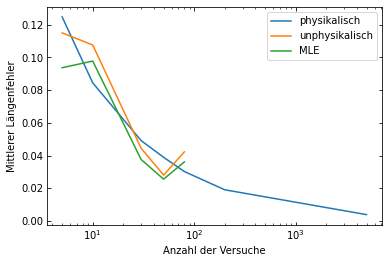

In [4]:
plt.plot(experiments, history[::3], label='physikalisch')
plt.plot(experiments, history[1::3], label='unphysikalisch')
plt.plot(experiments, history[2::3], label='MLE')
plt.xscale('log')
plt.xlabel('Anzahl der Versuche')
plt.ylabel('Mittlerer Längenfehler')
plt.tick_params('y', right=True, which='both', direction='in')
plt.tick_params('x', top=True, which='both', direction='in')

plt.legend()
plt.show()

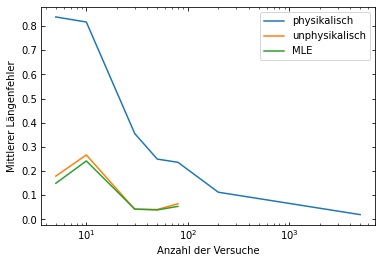

In [5]:
plt.plot(experiments, history_rme[0::3], label='physikalisch')
plt.plot(experiments, history_rme[1::3], label='unphysikalisch')
plt.plot(experiments, history_rme[2::3], label='MLE')
plt.xscale('log')
plt.xlabel('Anzahl der Versuche')
plt.ylabel('Mittlerer Längenfehler')
plt.tick_params('y', right=True, which='both', direction='in')
plt.tick_params('x', top=True, which='both', direction='in')

plt.legend()
plt.show()

## Erwartungswert der Polarisation

## Maximum likelihood estimate
Hier soll ein Maximum likelihodd estimate für den Blochvektor $\mathbf{R}_\mathrm{reconst.}$ bestimmt werden.
Dafür wird der Ausdruck $D_{KL}(\mathbf{r}_d \vert \mathbf{R}) = \ln\left[\frac{\mathcal{P}(\mathbf{r}_d)}{\mathcal{P}(\mathbf{R})}\right]$ minimiert